# Employee 'Attrition Risk Score' Model

## Objective
The purpose of this notebook is to delve into the factors that contribute to employee attrition and to develop a predictive model that can identify at-risk employees. This will enable HR interventions to be more proactive and targeted.

## Context
Employee turnover can be costly and disruptive to an organization. By understanding the characteristics that lead to attrition, we can better manage talent and improve employee retention.

## Methodology
We'll be following a structured data science process:
1. **Data Preprocessing**: Prepare our dataset for analysis, dealing with missing values and encoding categorical variables.
2. **Exploratory Data Analysis (EDA)**: Uncover patterns and insights from the data through visualization and statistics.
3. **Feature Engineering**: Enhance our dataset by creating new features that could improve model performance.
4. **Modeling**: Build and evaluate predictive models for attrition. Initially, we'll focus on Logistic Regression and Random Forest models to leverage their interpretability and robustness respectively.
5. **Risk Scoring**: Develop a scoring system to quantify the risk of attrition for each employee.

## Models Used
- **Logistic Regression**: A go-to baseline model for binary classification problems, providing interpretable results.
- **Random Forest**: An ensemble learning method that is less prone to overfitting and is known for its high accuracy.

Throughout the notebook, we'll annotate steps with insights and rationale for the choices made. Let's get started!

In [1]:
#Imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score

# Set display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
# Function to read files and handle exceptions

IBM_dataset = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'

def read_file(filename):
    try:
        df = pd.read_csv(filename, low_memory=False)
        return df
    except FileNotFoundError:
        print('File not found. Please check the file path and try again.')
    except Exception as e:
        print(f'An error occurred: {e}')        

# Reading the dataset
attrition_df = read_file(IBM_dataset)

# Displaying the first few rows of the dataframes
display(attrition_df.head(5))

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Preprocessing

## Missing Data
We start by identifying and addressing missing values, crucial for model accuracy.

## Feature Engineering
- **Interaction Feature**: New 'Income_per_Year_of_Tenure' feature to analyze the income stability.
- **Age Bins**: Grouping age into bins to differentiate life stages.

## Infinite Values
Replacing infinite values with NaN to maintain data consistency.

## Imputation
Filling NaNs with median 'Income_per_Year_of_Tenure' by job role for precise imputation.

## Categorical Variables
Converting categories to binary for model compatibility using one-hot encoding.

These steps streamline the dataset for the subsequent modeling phase.

In [3]:
# Check for missing values
missing_values = attrition_df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [4]:
# Creating a new feature to capture income relative to years at company
attrition_df['Income_per_Year_of_Tenure'] = attrition_df['MonthlyIncome'] / attrition_df['YearsAtCompany']
# Binning 'Age' into categories
attrition_df['AgeBin'] = pd.cut(attrition_df['Age'], bins=[20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s'])


In [5]:
# Replace 'inf' values with NaN (some people worked at their companies for less than a year, so 'YearsAtCompany' is 0 in those cases)
attrition_df['Income_per_Year_of_Tenure'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate the median 'Income_per_Year_of_Tenure' for each 'JobRole'
medians = attrition_df.groupby('JobRole')['Income_per_Year_of_Tenure'].transform('median')

# Fill NaN values in 'Income_per_Year_of_Tenure' with their respective 'JobRole' median
attrition_df['Income_per_Year_of_Tenure'] = attrition_df['Income_per_Year_of_Tenure'].fillna(medians)

In [6]:
attrition_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Income_per_Year_of_Tenure,AgeBin
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,998.833333,40s
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,513.000000,40s
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,714.493056,30s
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,363.625000,30s
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,1734.000000,20s


In [7]:
# Convert categorical variables to numerical using get_dummies for one-hot encoding
attrition_df_cat = pd.get_dummies(attrition_df, drop_first=True)

In [8]:
# Scale features using StandardScaler
scaler = StandardScaler()

numerical_features = attrition_df_cat.select_dtypes(include=['int64', 'float64']).columns
binary_features = attrition_df_cat.select_dtypes(include=['uint8']).columns

# Exclude binary features from scaling
numerical_features_for_scaling = numerical_features.difference(binary_features)

# Apply scaling
attrition_df_cat[numerical_features_for_scaling] = scaler.fit_transform(attrition_df_cat[numerical_features_for_scaling])

attrition_df_cat.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Income_per_Year_of_Tenure,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,AgeBin_30s,AgeBin_40s,AgeBin_50s
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,-1.150554,-0.426230,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834,-0.256043,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,2.129306,2.346151,1.191438,0.0,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541,-0.489181,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,-0.057267,-0.426230,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935,-0.392490,True,False,True,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,True,False,False
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,-1.150554,-0.426230,0.266233,0.0,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935,-0.560862,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,-0.877232,-0.426230,1.191438,0.0,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227,0.096742,False,False,True,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False


In [9]:
# Find boolean columns in the dataframe
bool_cols = [col for col in attrition_df.columns if attrition_df[col].dtype == 'bool']

# Convert boolean columns to binary (integers)
for col in bool_cols:
    attrition_df[col] = attrition_df[col].astype(int)

## Balancing the Dataset with SMOTE

This dataset contained a noticeable imbalance in the 'Attrition' column. Naturally, more people stayed at their companies than left. Imbalanced classes can lead to biased models that favor the majority class. To address this, we've used SMOTE (Synthetic Minority Over-sampling Technique) which synthesizes new examples for the minority class. This makes our dataset balanced, improving the likelihood of our models to generalize well and be fair in predictions across both classes.

In [10]:
# Preparing feature set (X) and target variable (y)
X = attrition_df_cat.drop('Attrition_Yes', axis=1)
y = attrition_df_cat['Attrition_Yes']


# Implementing SMOTE to tackle class imbalance
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X, y)

# Splitting the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=7)

## Exploratory Data Analysis (EDA)

The focus of the EDA was on discerning the features most correlated with attrition and examining the distribution of various variables across attrition outcomes.

### Correlation Analysis
Correlation coefficients between all features and the target variable 'Attrition_Yes' were computed to identify factors closely associated with attrition. A bar chart visualizes these correlations, highlighting the strength and direction of relationships.

### Feature Importance
Feature importances were extracted from a trained RandomForestClassifier to determine which features are deemed most predictive of attrition, providing insight into the factors that influence the model's predictions.

### Boxplot Visualizations
I generated boxplots for key features such as 'Age', 'MonthlyIncome', and 'JobSatisfaction' by attrition status. These plots reveal how the central tendency and dispersion of these features differ between employees who left and those who stayed.

#### Key Insights:
- Variables like 'Overtime', 'JobRole', and 'MaritalStatus' show strong correlations with attrition, suggesting they play a significant role in an employee's decision to leave.
- The RandomForestClassifier identified features like 'MonthlyIncome' and 'Age' as highly influential, indicating their significance in predicting attrition.
- Boxplots show noticeable differences in the distribution of 'MonthlyIncome' and 'JobSatisfaction' between the two groups, with those who left generally having lower income and job satisfaction levels.

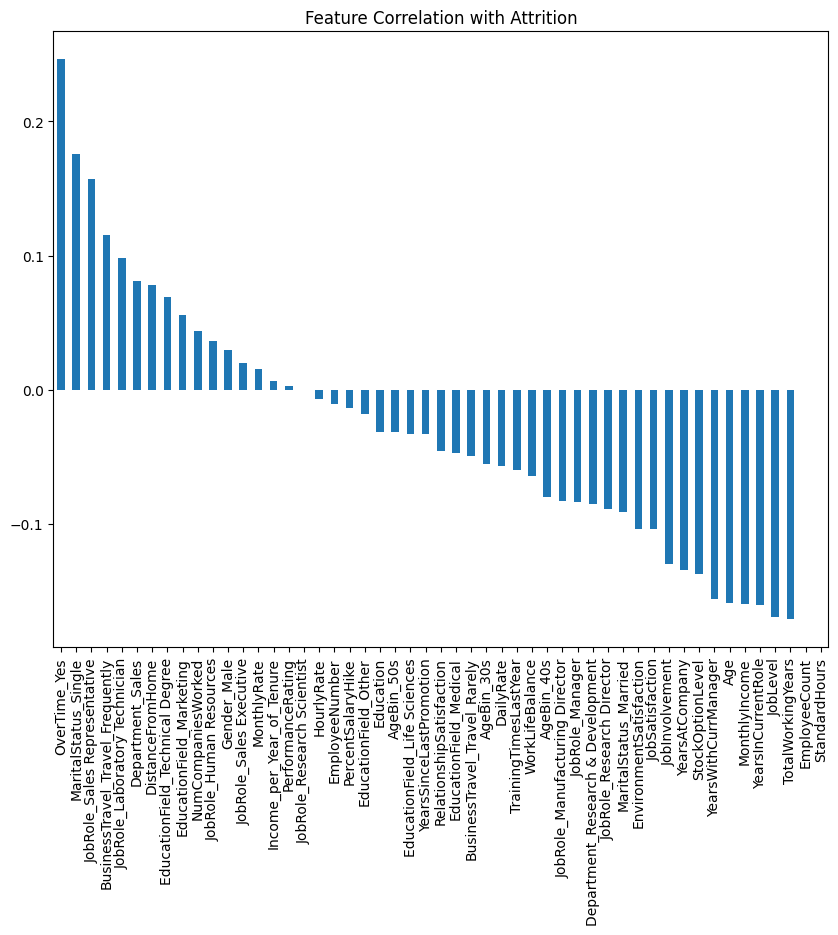

In [11]:
# Calculate correlations with the target variable
correlations = attrition_df_cat.corr()['Attrition_Yes'] 
correlations = correlations.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 8))
correlations.drop('Attrition_Yes').plot(kind='bar')
plt.title('Feature Correlation with Attrition')
plt.show()


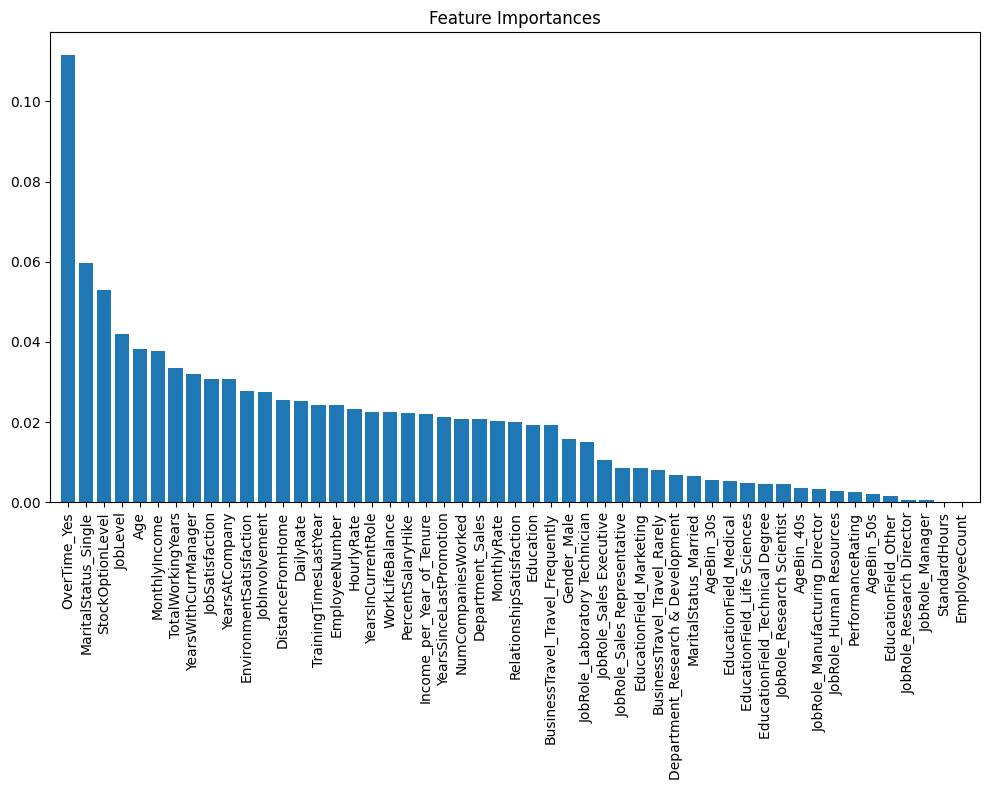

In [12]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()

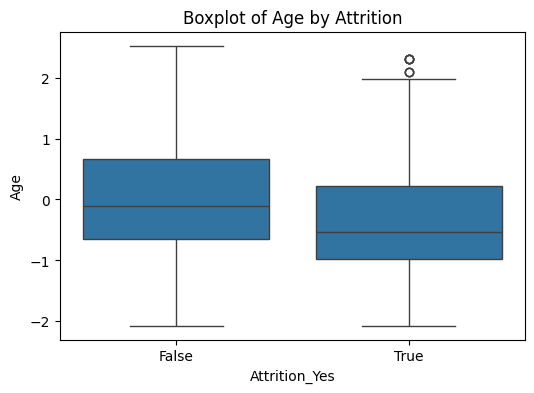

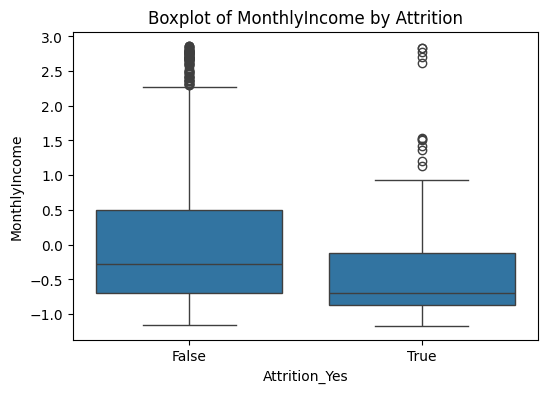

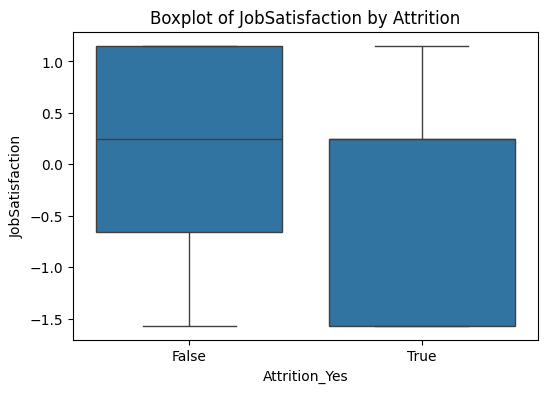

In [13]:
# Plot boxplots for key features
key_features = ['Age', 'MonthlyIncome', 'JobSatisfaction']
for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Attrition_Yes', y=feature, data=attrition_df_cat)
    plt.title(f'Boxplot of {feature} by Attrition')
    plt.show()

## Modeling and Risk Score Calculation

The methodology for predicting employee attrition included training Logistic Regression and Random Forest models. Both models were trained on a balanced dataset achieved through SMOTE to address the original class imbalance. The models' performances were evaluated using classification reports, which provide metrics such as precision, recall, and F1-score, as well as the AUC score to gauge their ability to discriminate between classes.

### Model Results
The Logistic Regression model achieved a strong AUC score, indicating good classification capabilities. The Random Forest model exhibited a higher AUC score, suggesting it may be more adept at distinguishing between employees who will leave and those who will stay.

### Attrition Risk Scores
An attrition risk score was calculated as the probability of attrition, as predicted by each model for a given set of employee features. This score is presented as a percentage, reflecting the likelihood of an employee leaving the company. For example, an attrition risk score of 10% from the Logistic Regression model implies a 10% chance of the employee leaving, according to the model's prediction.

In [14]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=7)

# Initialize the models
logreg = LogisticRegression(max_iter=1000, random_state=7)
rf = RandomForestClassifier(n_estimators=100, random_state=7)

# Train the models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions
logreg_pred = logreg.predict(X_test)
rf_pred = rf.predict(X_test)

# Performance evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logreg_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Calculate the predicted probabilities for Logistic Regression
logreg_prob = logreg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate AUC score for Logistic Regression
logreg_auc = roc_auc_score(y_test, logreg_prob)
print(f"Logistic Regression AUC: {logreg_auc}")

# Calculate the predicted probabilities for Random Forest
rf_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate AUC score for Random Forest
rf_auc = roc_auc_score(y_test, rf_prob)
print(f"Random Forest AUC: {rf_auc}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.92      0.90       349
        True       0.92      0.88      0.90       391

    accuracy                           0.90       740
   macro avg       0.90      0.90      0.90       740
weighted avg       0.90      0.90      0.90       740


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.96      0.92       349
        True       0.96      0.89      0.92       391

    accuracy                           0.92       740
   macro avg       0.92      0.93      0.92       740
weighted avg       0.93      0.92      0.92       740

Logistic Regression AUC: 0.9619372851918891
Random Forest AUC: 0.9770920203137938


In [15]:
# Selecting features for an example employee and calculating attrition risk scores
employee_features = X_test.iloc[0].values.reshape(1, -1)
attrition_risk_score_logreg = logreg.predict_proba(employee_features)[0][1] * 100  # As a percentage
attrition_risk_score_rf = rf.predict_proba(employee_features)[0][1] * 100  # As a percentage

# Displaying the risk scores
print(f"Attrition Risk Score (Logistic Regression): {attrition_risk_score_logreg:.2f}%")
print(f"Attrition Risk Score (Random Forest): {attrition_risk_score_rf:.2f}%")

Attrition Risk Score (Logistic Regression): 99.81%
Attrition Risk Score (Random Forest): 82.00%


/Users/jevans/Documents/data_science/15Five/15five_venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/jevans/Documents/data_science/15Five/15five_venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [19]:

employee_features_df = pd.DataFrame(employee_features, columns=X_test.columns)
employee_features_df

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Income_per_Year_of_Tenure,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,AgeBin_30s,AgeBin_40s,AgeBin_50s
0,-0.136216,-0.151357,-0.339639,0.631974,0.0,-1.471711,-0.550802,-0.077304,-0.857604,-0.563815,-0.769611,-0.567168,1.264871,-0.005344,2.096534,2.346151,1.191438,0.0,-0.932014,-0.437058,0.155707,0.338096,-0.223346,-0.008009,-0.679146,-0.10175,-0.407166,True,True,True,False,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,True,True,True,False,False
